Install necessary packages

# 0. Instllation of Packages

1. Get the CUDA version -- Got the 10.2
2. Install torch for CUDA 10.2.
3. Install sentencepiece otherwise, not able to install other packages
4. Check the Torch version, it should 1.5
5. Check Cuda Torch version, it should be 10.2
6. Check the Cuda availability, it should be available
7. Install Detectron2

In [1]:
!nvidia-smi

Thu Jun 25 18:08:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   28C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install -U torch==1.5 torchvision==0.6 -f \
    https://download.pytorch.org/whl/cu102/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install sentencepiece
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
Requirement already up-to-date: torch==1.5 in /anaconda/envs/py37_pytorch/lib/python3.7/site-packages (1.5.0)
Requirement already up-to-date: torchvision==0.6 in /anaconda/envs/py37_pytorch/lib/python3.7/site-packages (0.6.0)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6q3q_5qk
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6q3q_5qk
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=102206 sha256=1f54267440288152607a318f5ee8d087fdb41da5643bf4f81fdf8a2eb9b7c024
  Stored in directory: /tmp/pip-ephem-wheel-cache-ebdw8wnu/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3u

Check the version of Torch and Torch Cuda and availability of the GPU

In [3]:
import torch, torchvision
print("Torch Version is ", torch.__version__)
print("Torch CUDA Version is ", torch.version.cuda)
if (torch.cuda.is_available()):
    print("GPU avaible")
else:
    print("GPU is not available") 

Torch Version is  1.5.0
Torch CUDA Version is  10.2
GPU avaible


Install Detectron 2

In [4]:
!pip install detectron2 -f \
      https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.5/index.html     

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.5/index.html


# 1. Import Necessary Packages

In [5]:
%matplotlib inline

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
from os import listdir
from os.path import isfile, join, splitext

import matplotlib.pyplot as plt

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training object detector
from detectron2.engine import DefaultTrainer
# DefaultPredictor is class for inference
from detectron2.engine import DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg
# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# BoxMode support bounding boxes in different format
from detectron2.structures import BoxMode

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

# 2 Data Constants

In [7]:
working_dir = os.getcwd()
print('Working Directory = ', working_dir)
data_input_path = os.path.join(working_dir, 'data', 'input')
data_output_path = os.path.join(working_dir, 'data', 'output')
logs_path = os.path.join(working_dir, 'logs')
print('Data input path = ', data_input_path)
print('Data output path = ', data_output_path)
print('Logs path = ', logs_path)

Working Directory =  /home/prem/notebooks/project_3
Data input path =  /home/prem/notebooks/project_3/data/input
Data output path =  /home/prem/notebooks/project_3/data/output
Logs path =  /home/prem/notebooks/project_3/logs


In [8]:
# configurations
data_root = 'Dataset'
train_path = 'train'
test_path = 'validation'
vehicle_images_path = 'Vehicle registration plate'
vehicle_labels_path = 'Label'

train_data_name = 'vehicle_reg_train'
test_data_name = 'vehicle_reg_test'

output_dir = 'outputs'

thing_classes = ['Reg-plate']

# 3 Download the Data

1. Download the Data (Dataset) to data/input folder of the current working directory
2. Extract the data to data/input folder of the current working directory

In [9]:
#!wget https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip -P data/input/
#!unzip data/input/Dataset.zip -d data/input/

## Get Files
Get the Files in a specific directory
1. Get the Files of training images, labels
2. Get the files of test images, labels

In [10]:
def get_files(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()

    return files

In [11]:
train_images_path = os.path.join(data_input_path, data_root, train_path,
                                 vehicle_images_path)
print('Train Images Path =', train_images_path)
train_image_files = get_files(train_images_path)
print('No. Train Images = ', len(train_image_files))


train_labels_path = os.path.join(data_input_path, data_root, train_path,
                                 vehicle_images_path, vehicle_labels_path)
print('Train Labels Path =', train_labels_path)
train_label_files = get_files(train_labels_path)
print('No. Train Labels = ', len(train_label_files))

test_images_path = os.path.join(data_input_path, data_root, test_path,
                                vehicle_images_path)
print('Test Images Path =', test_images_path)
test_image_files = get_files(test_images_path)
print('No. Test Images = ', len(test_image_files))
test_labels_path = os.path.join(data_input_path, data_root, test_path,
                                vehicle_images_path, vehicle_labels_path)
print('Test Labels Path =', test_labels_path)
test_label_files = get_files(test_labels_path)
print('No. Test Labels = ', len(test_label_files))


Train Images Path = /home/prem/notebooks/project_3/data/input/Dataset/train/Vehicle registration plate
No. Train Images =  5308
Train Labels Path = /home/prem/notebooks/project_3/data/input/Dataset/train/Vehicle registration plate/Label
No. Train Labels =  5308
Test Images Path = /home/prem/notebooks/project_3/data/input/Dataset/validation/Vehicle registration plate
No. Test Images =  386
Test Labels Path = /home/prem/notebooks/project_3/data/input/Dataset/validation/Vehicle registration plate/Label
No. Test Labels =  386


## Get the Dictionary

In [12]:
def get_vehicle_reg_dicts(images_path, image_files, labels_path, label_files):
    dataset_dicts = []
    
    for index in range(len(image_files)):
        record = {}
        image_path = os.path.join(images_path, image_files[index])
        image_height, image_width = cv2.imread(image_path).shape[:2]

        record['file_name'] = image_path
        record['image_id'] = index
        record['height'] = image_height
        record['width'] = image_width

        annotation_rows = []
        label_path = os.path.join(labels_path, label_files[index])
        with open(label_path, "r") as text_file:
            for line in text_file:
                data = line.rstrip().split(" ")
                annotation_rows.append(data)
                
        objs = []        
        for row in annotation_rows:  
            #Ignore row 0, 1, 2 as it contains Vehicle registration plate          
            x_min = int(float(row[3]))
            y_min = int(float(row[4]))
            x_max = int(float(row[5]))
            y_max = int(float(row[6]))
    
            obj = {
                'bbox': [x_min, y_min, x_max, y_max],
                'bbox_mode': BoxMode.XYXY_ABS,
                # alternatively, we can use bbox_mode = BoxMode.XYWH_ABS
                # 'bbox': [xmin, ymin, bwidth, bheight],
                # 'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': 0,
                'iscrowd': 0
            }
        
            objs.append(obj)           

        record['annotations'] = objs
        dataset_dicts.append(record)

    return dataset_dicts    

## Create Train and Test Data Set



In [13]:
# Register train and test data
# dataset can be registered only once with one name

# register train data

DatasetCatalog.register(name = train_data_name, 
                        func = lambda: get_vehicle_reg_dicts(
                        train_images_path, train_image_files, train_labels_path,
                        train_label_files))
train_metadata = MetadataCatalog.get(train_data_name).set(thing_classes = thing_classes)

# register test data
DatasetCatalog.register(name = test_data_name, 
                        func = lambda: get_vehicle_reg_dicts(
                        test_images_path, test_image_files, test_labels_path,
                        test_label_files))
test_metadata = MetadataCatalog.get(test_data_name).set(thing_classes = thing_classes)

## Visualize the Test Data
Display 3 random images with bounding box of test images

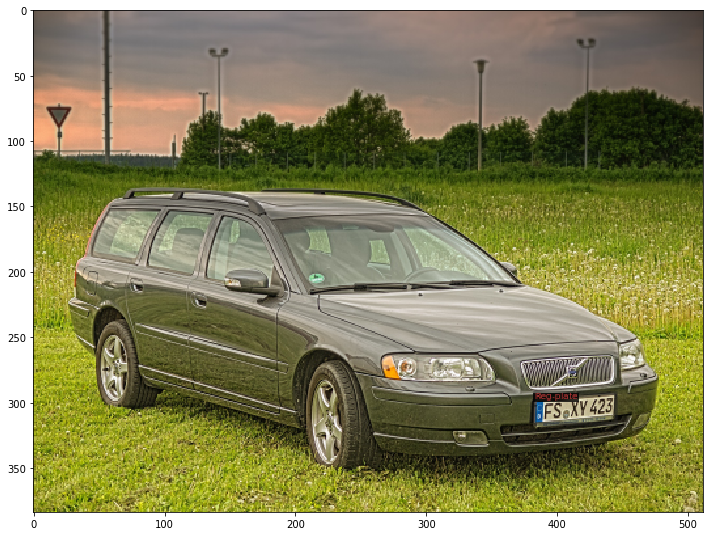

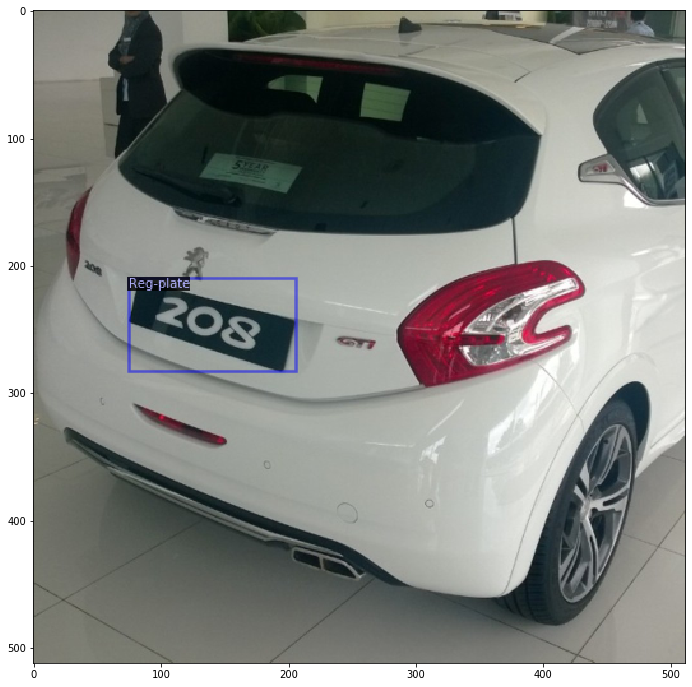

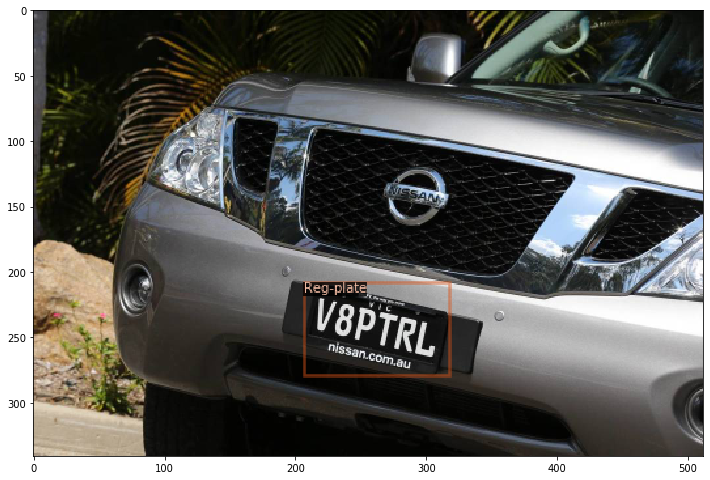

In [14]:
# lets visualize the data

test_data_dict = get_vehicle_reg_dicts(test_images_path, test_image_files,
                                       test_labels_path, test_label_files)

for d in random.sample(test_data_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=test_metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Detectron2 Configuration

Get default configuration of detectron2 and update parameters according to our requirements. 

In [15]:
# detectron2 configuration

# default confugration
cfg = get_cfg()

# update configuration with RetinaNet configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# We have registered the train and test data set with name traffic_sign_train and traffic_sign_test. 
# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()

Loading config /anaconda/envs/py37_pytorch/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [16]:
# data loader configuration
cfg.DATALOADER.NUM_WORKERS = 4


In [17]:
# Update model URL in detectron2 config file
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

In [18]:
# slover configuration

# batch size
cfg.SOLVER.IMS_PER_BATCH = 4

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.001

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
# lets convert number of epoch to number or iteration (max iteration)

epoch = 2
max_iter = int(epoch * len(train_image_files) / cfg.SOLVER.IMS_PER_BATCH)
max_iter = 500

cfg.SOLVER.MAX_ITER = max_iter

In [19]:
# number of output class
# we have only one class that is Traffic Sign
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)

In [20]:
# update create ouptput directory 
cfg.OUTPUT_DIR = output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Set up TensorBoard

Before starting the training, let's set up the TensorBoard.


In [21]:

# Look at training curves in tensorboard:

%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir outputs


## Tensorboard Data logs

Following link contains Tensorboard Data logs

https://tensorboard.dev/experiment/mjm1Jpu1SVO9n3pDEXzRYw/#scalars

# Training

In [22]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

# if rseume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()


[06/25 18:10:03 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Unable to load 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model!
Unable to load 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model!


[06/25 18:12:30 d2.engine.train_loop]: Starting training from iteration 0
[06/25 18:13:20 d2.utils.events]:  eta: 0:20:27  iter: 19  total_loss: 1.392  loss_cls: 1.027  loss_box_reg: 0.388  time: 2.5644  data_time: 0.0182  lr: 0.000020  max_mem: 4089M
[06/25 18:14:12 d2.utils.events]:  eta: 0:19:43  iter: 39  total_loss: 1.455  loss_cls: 1.156  loss_box_reg: 0.311  time: 2.5635  data_time: 0.0097  lr: 0.000040  max_mem: 4089M
[06/25 18:15:04 d2.utils.events]:  eta: 0:18:51  iter: 59  total_loss: 1.186  loss_cls: 0.811  loss_box_reg: 0.346  time: 2.5820  data_time: 0.0093  lr: 0.000060  max_mem: 4089M
[06/25 18:15:56 d2.utils.events]:  eta: 0:18:02  iter: 79  total_loss: 1.005  loss_cls: 0.759  loss_box_reg: 0.186  time: 2.5830  data_time: 0.0089  lr: 0.000080  max_mem: 4089M
[06/25 18:16:48 d2.utils.events]:  eta: 0:17:18  iter: 99  total_loss: 0.813  loss_cls: 0.626  loss_box_reg: 0.201  time: 2.5923  data_time: 0.0087  lr: 0.000100  max_mem: 4089M
[06/25 18:17:40 d2.utils.events]:  e

# Interference

Interference with the test data set

In [23]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# update RetinaNet score threshold 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

cfg.DATASETS.TEST = (test_data_name,)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)

## Visualise the Predicted Data
Visualize 3 random predicated data

/home/prem/notebooks/project_3/data/input/Dataset/validation/Vehicle registration plate/326c3286bcb5b2b0.jpg
{'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[739.5711, 419.6304, 865.8479, 513.4592]], device='cuda:0')), scores: tensor([0.9527], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


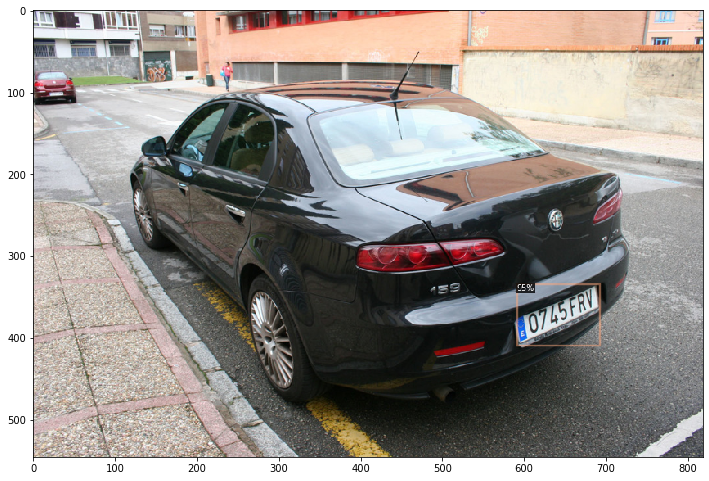

/home/prem/notebooks/project_3/data/input/Dataset/validation/Vehicle registration plate/fa9147596edc058f.jpg
{'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[620.9453, 408.7570, 708.4298, 472.6381]], device='cuda:0')), scores: tensor([0.7787], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


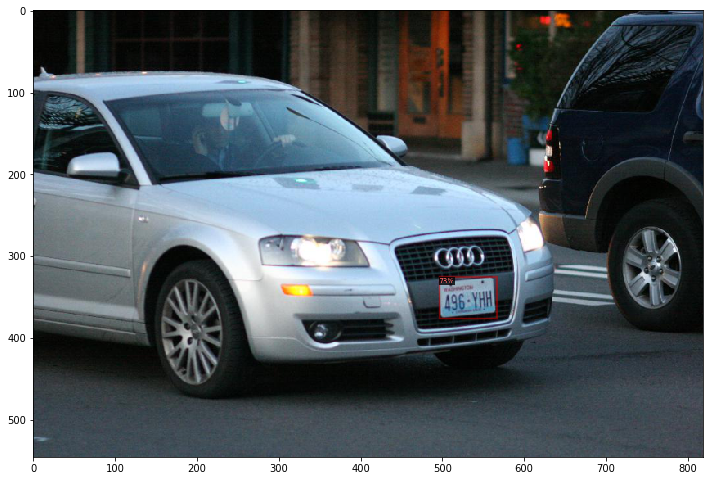

/home/prem/notebooks/project_3/data/input/Dataset/validation/Vehicle registration plate/5641e6ad7d2600f2.jpg
{'instances': Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[154.6801, 496.0130, 313.1283, 599.5283]], device='cuda:0')), scores: tensor([0.7609], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


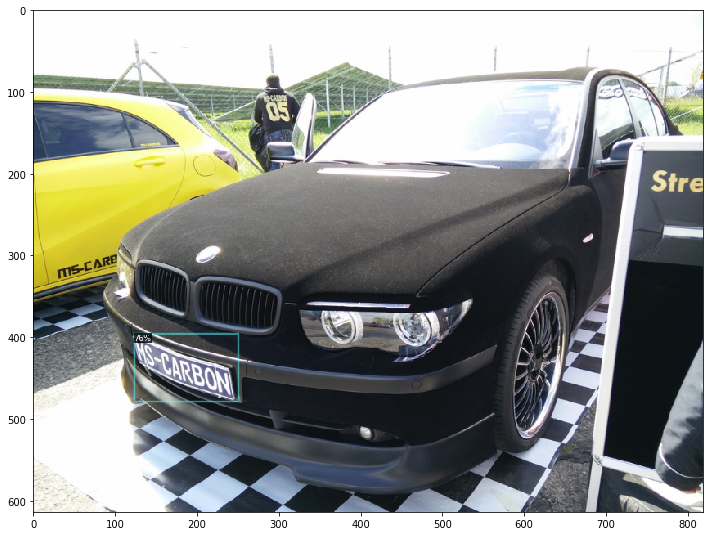

In [24]:
# let's have a look on prediction

for d in random.sample(test_data_dict, 3):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (12, 12))
    plt.imshow(v.get_image())
    plt.show()

# COCO Detection Evaluation

Evaluate the model with COCO Detection

In [25]:

# create directory for evaluation
eval_dir = os.path.join(cfg.OUTPUT_DIR, 'coco_eval')
os.makedirs(eval_dir, exist_ok=True)

# create evaluator instance with coco evaluator
evaluator = COCOEvaluator(dataset_name=test_data_name, 
                          cfg=cfg, 
                          distributed=False, 
                          output_dir=eval_dir)

# create validation data loader
val_loader = build_detection_test_loader(cfg, test_data_name)

# start validation
inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [06/25 18:34:32 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'vehicle_reg_test'. Trying to convert it to COCO format ...
WARNING [06/25 18:34:32 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'outputs/coco_eval/vehicle_reg_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/25 18:34:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| Reg-plate  | 512          |
|            |              |
[06/25 18:34:38 d2.data.common]: Serializing 386 elements to byte tensors and concatenating them all ...
[06/25 18:34:38 d2.data.common]: Serialized dataset takes 0.12 MiB
[06/25 18:34:38 d2.evaluation.evaluator]: Start inference on 386 images
[06/25 18:34:42 d2.evaluation.evaluator]: Inference done 11/386. 0.3384 s / img. ETA=0:02:07
[06/25 18:34:47 d2.evaluation.evaluator]: Inference done 27/386. 0.3262 s / 

OrderedDict([('bbox',
              {'AP': 52.74307997555589,
               'AP50': 82.47289098787918,
               'AP75': 62.166507068881636,
               'APs': 18.43251856638225,
               'APm': 64.78876142240605,
               'APl': 63.19406476538239})])

# Interference on a Video
Test the predicted model on video

## Input Video
Read the Input video from the YouTube and display 

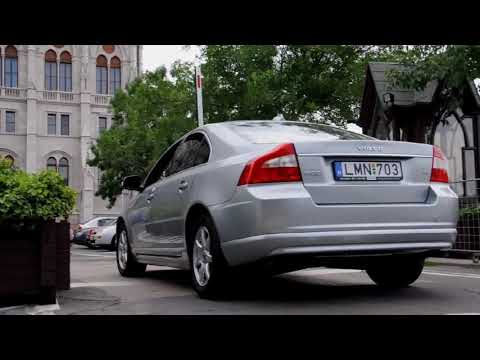

In [26]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

## Genearate the Predicted Video
Read the input video, get each frame from the video, predicte the bounding box and score and then write into output vide0.

In [29]:
import math
def video_read_write(video_in_path, video_out_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_in_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    
    
    output_file = cv2.VideoWriter(
        filename = video_out_path,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G'),
        fps = float(frames_per_second),
        frameSize = (width, height),
        isColor = True,
    )
    
    # font 
    text_font = cv2.FONT_HERSHEY_SIMPLEX 
  
     
    # fontScale 
    text_scale = 1
   
    # Blue color in BGR 
    text_color = (0, 0, 255) 
  
    # Line thickness of 2 px 
    text_thickness = 2
   
    # Using cv2.putText() method 
    
    
    while video.isOpened():
        ret, frame = video.read()
        if ret:            
            outputs = predictor(frame)            
            boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()
            scores = outputs['instances'].scores.cpu().numpy()            
            if (len(boxes) > 0):
                #print(frame.shape)
                width = frame.shape[1]
                height = frame.shape[0]
                box = boxes[0]
                #print(box)
                #print(scores[0])
                y1 = math.ceil(box[0])
                x1 = math.ceil(box[1])
                y2 = math.ceil(box[2])
                x2 = math.ceil(box[3])
                cv2.rectangle(frame, (y1, x1), (y2, x2),(0,255,0), 3)
                
                # org 
                #text_org = (y1 - 50, x1 - 20) 
                
                text_org = (y1 - 5, x1 - 5) 
                score = int(float(scores[0]) * 100)
                s_score = str(score) + '%'
                frame = cv2.putText(frame, s_score, text_org, text_font,  
                                    text_scale, text_color, text_thickness, cv2.LINE_AA)
                #output_file.write(text_frame)
                #cv2.imwrite('test.png', frame)
                #break
                
            
            output_file.write(frame)
            
        else:
            break
        
    video.release()
    output_file.release()
    
    return

In [30]:
video_in_file_name = 'projet3-input-video.mp4'
video_in_path = os.path.join(data_input_path, video_in_file_name)
#print(video_in_path)
video_out_file_name = 'projet3-output-video.avi'
video_out_path = os.path.join(data_output_path, video_out_file_name)
#print(video_out_path)
video_read_write(video_in_path, video_out_path)


## Output video - Youtube

https://youtu.be/SB_0Aq2r1No